# <font color='darkblue'> Sparkify Full Dataset EDA and Feature Engineering</font>

<div class="alert alert-block alert-info">

This notebook is dedicated to the following tasks:
    <li> cleaning and preprocessing full dataset, </li>
    <li> feature engineering on the full dataset, </li>
    <li> EDA on the processed full dataset, </li>
    <li> stratified split of the data into training and test sets, </li>
    <li> feature relevance and feature selection considerations.</li>
</div>

## <font color='blue'>Set Environment</font>

In [1]:
# import PySpark libraries and packages

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.window import Window as W

from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    
    col, lit, 
    first, last, 
    desc, asc,
    avg, count, countDistinct, 
    when, isnull, isnan,
    from_unixtime, 
    datediff,
    )

In [4]:
# build a Spark session using the SparkSession APIs

spark = (SparkSession
        .builder
        .appName("Sparkify")
        .getOrCreate())

spark.sparkContext.setLogLevel("WARN")

In [5]:
# import python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# import library for enhanced plotting

import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette('PuBuGn_r')

## <font color='blue'>Load and Clean Dataset</font>

In [7]:
def load_data(file_path):
    """
    Loads the raw dataset in Spark.
    
    INPUT:
            (str) - path for datafile
    OUTPUT:
            (PySpark dataframe) - dataframe of raw data
    
    """
    
    print("Loading the dataset ...")
    df = spark.read.json(file_path)
    print("Dataset is loaded...")
    
    return df


In [8]:
def clean_data(df):
    """
    Performs basic cleaning operations on the raw data:
        - removes entries with missing userId
        - rescale timestamp columns to seconds
        - drop unnecesary columns
            - personal information columns
            - song information columns
            - web and browser information
            - timestamp columns in miliseconds
    
    INPUT:
            (PySpark dataframe) - dataframe of raw data
    OUTPUT:
            (PySpark dataframe) - dataframe of cleaned data
    """
    
    # print message to indicate the start of the process
    print("Cleaning the data ...")
    
    # print a count of rows before cleaning
    initial_records = df.count()
    print("Dataset has {} rows initially.".format(initial_records))
    
    # filter out all the records without userId
    df = df.where(df.userId != "")
    
    # rescale the timestamp to seconds (initially in miliseconds)
    df = df.withColumn("log_ts", df.ts/1000.0)
    df = df.withColumn("reg_ts", df.registration/1000.0)
    
    # drop several columns 
    cols_to_drop = ("firstName", "lastName", "location",
                    "artist", "song", "length",
                    "userAgent", "method", "status",
                    "ts", "registration"
                   )
    df = df.drop(*cols_to_drop)

    
    # print end of process message
    print("Finished cleaning the data ...")
    
    # print a count of rows after cleaning
    removed_rows = initial_records - df.count()
    
    print("Cleaned dataset has {} rows, {} rows were removed". \
        format(df.count(), initial_records - df.count()))
    
    return df
    

In [9]:
def save_data(df, data_path):
    """
    Saves the PySpark dataframe to a file.
    
    INPUT:
            df (PySpark dataframe) - data to be saved
            data_path (str) - path for datafile
    OUTPUT:
            none
    
    """
    
    df.write.json(data_path)

In [10]:
# create a path variable for the full dataset file
full_data_path = "data/full_sparkify_event_data.json"

In [11]:
# read the full dataset
full_sparkify = load_data(full_data_path)
# clean the full dataset
df = clean_data(full_sparkify)

Loading the dataset ...


Dataset is loaded...
Cleaning the data ...


Dataset has 26259199 rows initially.
Finished cleaning the data ...


Cleaned dataset has 26259199 rows, 0 rows were removed


In [ ]:
# path for the cleaned data
clean_full_data_path = "data/full_sparkify_clean_data.json"

# save the cleaned data to a file
#save_data(df, clean_data_path)

# upload the clean data
#df = load_data(clean_data_path)

In [12]:
# check the structure of the data after cleaning
df.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- log_ts: double (nullable = true)
 |-- reg_ts: double (nullable = true)



In [13]:
# take a look at the cleaned data
df.show(1, vertical=True)

-RECORD 0----------------------
 auth          | Logged In     
 gender        | M             
 itemInSession | 278           
 level         | paid          
 page          | NextSong      
 sessionId     | 22683         
 userId        | 1749042       
 log_ts        | 1.538352001E9 
 reg_ts        | 1.533734541E9 
only showing top 1 row



### <font color='blue'>Toggle the memory</font>

In [14]:
# save to storage level 'MEMORY'
df_cached = df.cache()

## <font color='blue'>Preprocess Dataset</font>

In [15]:
def preprocess_data(df):
    
    """
    Prepare the data for modeling via creating several features.
    
     - reg_date (date) - month-year of the registration 
     
     - create windows grouped on userId and sessionId 
     
     - firstevent_ts (timestamp) - first time an user is active
     - lastevent_ts (timestamp) - last time an user is active
     
     - init_days_interv (float) - days between registration and first activity
     - tenure_days_interv (float) - days between registration and last activity
     - active_days (float) - days the user has some activity on the platform
     - session_h (float) - session's duration in hours
     
     INPUT:
         df (PySpark dataframe) - cleaned dataframe
     OUTPUT:
         df (PySpark dataframe) - dataframe with the listed features added
    """
    
    # extract registration month and year from timestamp
    df = df.withColumn("reg_date", from_unixtime(col("reg_ts"), "MM-yyyy")) 

    # create window: data grouped by userId, time ordered     
    win_user = (W.partitionBy("userId")
            .orderBy("log_ts")
            .rangeBetween(W.unboundedPreceding, W.unboundedFollowing))
    
    # create window: data grouped by sessionId and userId, time ordered
    win_user_session = (W.partitionBy("sessionId", "userId")
                    .orderBy("log_ts")
                    .rangeBetween(W.unboundedPreceding, W.unboundedFollowing))
    
    
    # record the first time an user is active
    df = df.withColumn("firstevent_ts", first(col("log_ts")).over(win_user))
    # record the last time an user is active
    df = df.withColumn("lastevent_ts", last(col("log_ts")).over(win_user))

    
    # warmup time = registration time to first event in days
    df = df.withColumn("init_days_interv", 
                       (col("firstevent_ts").cast("long")-col("reg_ts").cast("long"))/(24*3600))
    
    # tenure time = registration time to last event in days
    df = df.withColumn("tenure_days_interv",
                       (col("lastevent_ts").cast("long")-col("reg_ts").cast("long"))/(24*3600))
    
    # active time =  days between the first event and the last event in days
    df = df.withColumn("active_days",
                       (col("lastevent_ts").cast("long")-col("firstevent_ts").cast("long"))/(24*3600))

    # create column that records the individual session's duration in hours
    df = df.withColumn("session_h",
                    (last(df.log_ts).over(win_user_session) \
                     - first(df.log_ts).over(win_user_session))/3600)  
    
    # drop columns 
    df = df.drop("reg_ts", "log_ts")
    
    return df

In [16]:
# preprocess full dataset
df_proc = preprocess_data(df_cached)

In [17]:
# display the features in the preprocessed dataframe
df_proc.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- reg_date: string (nullable = true)
 |-- firstevent_ts: double (nullable = true)
 |-- lastevent_ts: double (nullable = true)
 |-- init_days_interv: double (nullable = true)
 |-- tenure_days_interv: double (nullable = true)
 |-- active_days: double (nullable = true)
 |-- session_h: double (nullable = true)



In [18]:
# take a look at the data
df_proc.show(1, vertical=True)

22/01/18 21:04:52 WARN MemoryStore: Not enough space to cache rdd_40_52 in memory! (computed 5.1 MiB so far)
22/01/18 21:04:52 WARN BlockManager: Persisting block rdd_40_52 to disk instead.
22/01/18 21:04:52 WARN MemoryStore: Not enough space to cache rdd_40_51 in memory! (computed 5.1 MiB so far)
22/01/18 21:04:52 WARN BlockManager: Persisting block rdd_40_51 to disk instead.
22/01/18 21:04:52 WARN MemoryStore: Not enough space to cache rdd_40_53 in memory! (computed 5.1 MiB so far)
22/01/18 21:04:52 WARN BlockManager: Persisting block rdd_40_53 to disk instead.
22/01/18 21:04:52 WARN MemoryStore: Not enough space to cache rdd_40_58 in memory! (computed 5.0 MiB so far)
22/01/18 21:04:52 WARN BlockManager: Persisting block rdd_40_58 to disk instead.
22/01/18 21:04:52 WARN MemoryStore: Not enough space to cache rdd_40_56 in memory! (computed 5.1 MiB so far)
22/01/18 21:04:52 WARN BlockManager: Persisting block rdd_40_56 to disk instead.
22/01/18 21:04:52 WARN MemoryStore: Not enough spa

22/01/18 21:04:59 WARN MemoryStore: Not enough space to cache rdd_40_71 in memory! (computed 5.1 MiB so far)
22/01/18 21:04:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_40_75 in memory.
22/01/18 21:04:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_40_76 in memory.
22/01/18 21:04:59 WARN MemoryStore: Not enough space to cache rdd_40_75 in memory! (computed 384.0 B so far)
22/01/18 21:04:59 WARN BlockManager: Persisting block rdd_40_75 to disk instead.
22/01/18 21:04:59 WARN MemoryStore: Not enough space to cache rdd_40_76 in memory! (computed 384.0 B so far)
22/01/18 21:04:59 WARN BlockManager: Persisting block rdd_40_76 to disk instead.
22/01/18 21:04:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_40_77 in memory.
22/01/18 21:04:59 WARN MemoryStore: Not enough space to cache rdd_40_77 in memory! (computed 384.0 B so far)


22/01/18 21:05:04 WARN BlockManager: Persisting block rdd_40_94 to disk instead.
22/01/18 21:05:05 WARN MemoryStore: Not enough space to cache rdd_40_87 in memory! (computed 4.6 MiB so far)
22/01/18 21:05:05 WARN BlockManager: Persisting block rdd_40_87 to disk instead.
22/01/18 21:05:05 WARN MemoryStore: Not enough space to cache rdd_40_85 in memory! (computed 4.7 MiB so far)
22/01/18 21:05:05 WARN BlockManager: Persisting block rdd_40_85 to disk instead.
22/01/18 21:05:05 WARN MemoryStore: Not enough space to cache rdd_40_84 in memory! (computed 4.8 MiB so far)
22/01/18 21:05:05 WARN BlockManager: Persisting block rdd_40_84 to disk instead.
22/01/18 21:05:06 WARN MemoryStore: Not enough space to cache rdd_40_87 in memory! (computed 4.6 MiB so far)
22/01/18 21:05:07 WARN MemoryStore: Not enough space to cache rdd_40_84 in memory! (computed 4.8 MiB so far)
22/01/18 21:05:07 WARN MemoryStore: Not enough space to cache rdd_40_89 in memory! (computed 4.6 MiB so far)
22/01/18 21:05:07 WARN

-RECORD 0--------------------------------
 auth               | Logged In          
 gender             | F                  
 itemInSession      | 0                  
 level              | paid               
 page               | NextSong           
 sessionId          | 54                 
 userId             | 1775420            
 reg_date           | 09-2018            
 firstevent_ts      | 1.540495406E9      
 lastevent_ts       | 1.543439125E9      
 init_days_interv   | 43.46186342592593  
 tenure_days_interv | 77.53268518518519  
 active_days        | 34.07082175925926  
 session_h          | 7.0072222222222225 
only showing top 1 row



In [19]:
# path for the processed full data
processed_full_data_path = "data/full_sparkify_processed_data.json"

# save the preprocessed data to a file
#save_data(df_proc, processed_data_path)

## <font color='blue'>Feature Engineering</font>

<div class="alert alert-block alert-info">
    
In this section:
<li> several new features are created,</li>
<li> a new PySpark dataframe with one row per user is created,</li>
<li> the target feature denoted "churn" is created from "Cancellation Confirmation" page.</li>

</div>

In [20]:
def build_features(df):
    
    """
    Features engineered to be used in modelling.
    
    - nr_songs (int) - total number of songs user listened to
    - nr_playlist (int) - number of songs added to the playlist
    
    - nr_friends (int) - number of friends added through "Add Friend"
    
    - nr_likes (int) - total number of "Thumbs Up" of the user
    - nr_dislikes (int) - total number of "Thumbs Down" of the user
    
    - nr_downgrades (int) - total number of visits to "Downgrade" page by the user
    - nr_upgrades (int) - total number of visits to "Upgrade" page by the user
    
    - nr_home (int) - total number of visits to "Home" page by the user
    - nr_settings (int) - total number of visits to "Settings" page by the user
    
    - nr_error (int) - total number of errors encountered by the user
   
    - nr_ads (int) - total number of ads the user got
    - nr_sessions (int) - number of sessions of the user
    - n_acts (int) - total number of actions taken by the user
    
    - avg_sess_h (float) - average session length in hours
    - acts_per_session (float) - average number of actions per session for the user
    - songs_per_session (float) - average numer of songs listened per session by the user
    - ads_per_session (float) - average number of ads per session, received by user
    
    - init_days_interv (int) - time interval in days from registration to the first action of the user
    - tenure_days_interv (int) - time interval in days from registration to the last action of the user
    - active_days (int) - number of days the user was active on the platform
    
    - gender (binary) - 1 for F (female), 0 for M (male)
    - level (binary) - 1 for paid, 0 for free
    
    - churn (binary) - 1 for "Cancellation Confirmation" page visit, 0 otherwise
    
    INPUT:
        df (PySpark dataframe) - preprocessed dataframe
        df_feats (PySpark datafrane) - dataframe that contains engineered features
    """
    
    df_feats = df.groupBy("userId") \
        .agg(
    
            # count user's individual actions using all page visits
    
            count(when(col("page") == "NextSong", True)).alias("nr_songs"),
            count(when(col("page") == "Add to Playlist", True)).alias("nr_playlist"),
        
            count(when(col("page") == "Add Friend", True)).alias("nr_friends"),
    
            count(when(col("page") == "Thumbs Up", True)).alias("nr_likes"),
            count(when(col("page") == "Thumbs Down", True)).alias("nr_dislikes"),
    
            count(when(col("page") == "Downgrade", True)).alias("nr_downgrades"),
            count(when(col("page") == "Upgrade", True)).alias("nr_upgrades"),
    
            count(when(col("page") == "Home", True)).alias("nr_home"),
            count(when(col("page") == "Settings", True)).alias("nr_settings"),
        
            count(when(col("page") == "Error", True)).alias("nr_error"),
    
            count(when(col("page") == "Roll Advert", True)).alias("nr_ads"),
    
            # compute the number of sessions a user is in
            countDistinct("sessionId").alias("nr_sessions"),
    
            # find the total number of actions a user took
            countDistinct("itemInSession").alias("n_acts"),
    
            # compute the average session length in hours
            avg(col("session_h")).alias("avg_sess_h"),
    
            # compute the average number of page actions per sesssion - i.e. items in session
            (countDistinct("itemInSession")/countDistinct("sessionId")).alias("acts_per_session"),
    
            # compute the average number of songs per session
            (count(when(col("page") == "NextSong",
                        True))/countDistinct("sessionId")).alias("songs_per_session"),
    
            # compute the average number of ads per session
             (count(when(col("page") == "Roll Advert",
                         True))/countDistinct("sessionId")).alias("ads_per_session"),
        
            # days between registration and first activity
            first(col("init_days_interv")).alias("init_days_interv"),
            # the tenure time on the platform: from registration to last event in days
            first(col("tenure_days_interv")).alias("tenure_days_interv"),
            # number of days user visited the platform, is active on the platform
            first(col("active_days")).alias("active_days"),
    
            # encode the gender 1 for F and 0 for M
            first(when(col("gender") == "F", 1).otherwise(0)).alias("gender"),
    
            # encode the level (paid/free) according to the last record
            last(when(col("level") == "paid", 1).otherwise(0)).alias("level"),
    
            # flag those users that downgraded 
            #last(when(col("page") == "Downgrade", 1).otherwise(0)).alias("downgrade"),
    
            # create the churn column that records if the user cancelled 
            last(when(col("page") == "Cancellation Confirmation", 1).otherwise(0)).alias("churn"),
            )
    # drop the column "userId" 
    df_feats = df_feats.drop("userId")  
    
    # drop the null values
    df_feats=df_feats.na.drop()
    
    return df_feats

In [21]:
# build the features dataframe for full dataset
df_feats = build_features(df_proc)

# check the output dataframe
df_feats.printSchema()

root
 |-- nr_songs: long (nullable = false)
 |-- nr_playlist: long (nullable = false)
 |-- nr_friends: long (nullable = false)
 |-- nr_likes: long (nullable = false)
 |-- nr_dislikes: long (nullable = false)
 |-- nr_downgrades: long (nullable = false)
 |-- nr_upgrades: long (nullable = false)
 |-- nr_home: long (nullable = false)
 |-- nr_settings: long (nullable = false)
 |-- nr_error: long (nullable = false)
 |-- nr_ads: long (nullable = false)
 |-- nr_sessions: long (nullable = false)
 |-- n_acts: long (nullable = false)
 |-- avg_sess_h: double (nullable = true)
 |-- acts_per_session: double (nullable = true)
 |-- songs_per_session: double (nullable = true)
 |-- ads_per_session: double (nullable = true)
 |-- init_days_interv: double (nullable = true)
 |-- tenure_days_interv: double (nullable = true)
 |-- active_days: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [ ]:
# path for the features data
features_data_path = "data/mini_sparkify_features_data.json"

# save the features data to a file
#save_data(df_feats, features_data_path)

### <font color='blue'>Toggle the memory</font>

In [22]:
# unpersist the dataframe df 
df_cached.unpersist()

DataFrame[auth: string, gender: string, itemInSession: bigint, level: string, page: string, sessionId: bigint, userId: string, log_ts: double, reg_ts: double]

In [23]:
# save the featured PySpark dataframe to memory
df_feats_cached = df_feats.cache()

22/01/18 21:06:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### <font color='blue'>Investigate missing and null values</font>

In [24]:
# count null and nan values in each column
df_feats_cached.select([count(when(isnan(c) | col(c).isNull(), c)) \
           .alias(c) for c in df_feats.columns]) \
           .show(vertical=True)

22/01/18 21:07:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:07:49 WARN RowBasedKeyValueBatch: Calling spill() on

-RECORD 0-----------------
 nr_songs           | 0   
 nr_playlist        | 0   
 nr_friends         | 0   
 nr_likes           | 0   
 nr_dislikes        | 0   
 nr_downgrades      | 0   
 nr_upgrades        | 0   
 nr_home            | 0   
 nr_settings        | 0   
 nr_error           | 0   
 nr_ads             | 0   
 nr_sessions        | 0   
 n_acts             | 0   
 avg_sess_h         | 0   
 acts_per_session   | 0   
 songs_per_session  | 0   
 ads_per_session    | 0   
 init_days_interv   | 0   
 tenure_days_interv | 0   
 active_days        | 0   
 gender             | 0   
 level              | 0   
 churn              | 0   



## <font color='blue'>Exploratory Data Analysis on Engineered Features</font>

In [25]:
# for visualizations we read PySpark dataframe into Pandas 
df_panda = df_feats_cached.toPandas()

### <font color='blue'>Distribution of Churn </font>

In [26]:
# the distribution of churn 

churn_counts = df_feats_cached.groupBy("churn").count()
churn_counts.show()

+-----+-----+
|churn|count|
+-----+-----+
|    1| 5001|
|    0|17276|
+-----+-----+



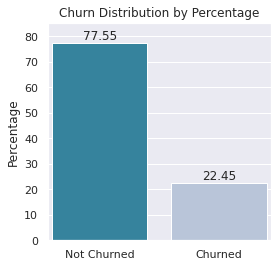

In [27]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax = sns.barplot(x='churn', y='churn', data=df_panda, 
                 estimator=lambda x: len(x) / len(df_panda) * 100,
                 palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
ax.set(xticklabels =["Not Churned", "Churned"])
ax.set(xlabel="")
ax.set(ylabel="Percentage")

# create title
plt.title("Churn Distribution by Percentage");


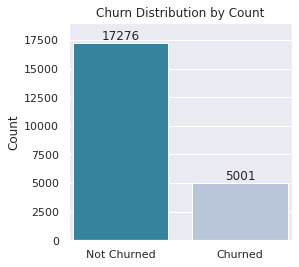

In [28]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax = sns.countplot(x='churn', data=df_panda, 
                palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax.containers:
    ax.bar_label(container)
    
ax.set(xticklabels =["Not Churned", "Churned"])
ax.set(xlabel="")
ax.set(ylabel="Count")

# create title
plt.title("Churn Distribution by Count");

In [29]:
# compute the churn rate via: churned/all users
churn_rate = round(df_feats.where(df_feats.churn==1).count() / df_feats.count(), 4)

print("The churned rate is {} %.".format(churn_rate * 100))

The churned rate is 22.45 %.


### <font color='blue'>Distribution of Churn on Gender</font>

In [30]:
# counts of churn/non_churn users grouped by gender
df_feats_cached.crosstab("churn", "gender").sort("churn_gender").show()

+------------+----+----+
|churn_gender|   0|   1|
+------------+----+----+
|           0|8997|8279|
|           1|2654|2347|
+------------+----+----+



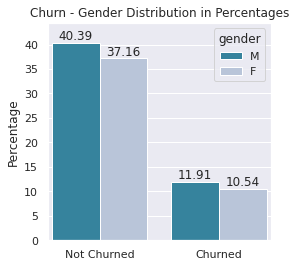

In [31]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax = sns.barplot(x='churn', y='churn', data=df_panda, 
                 estimator=lambda x: len(x) / len(df_panda) * 100, hue='gender',
                 palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
    
ax.set(xticklabels =["Not Churned", "Churned"])
ax.set(xlabel="")
ax.set(ylabel="Percentage")

# restyle legend
labels = ['M', 'F']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="gender")

# create title
plt.title("Churn - Gender Distribution in Percentages");

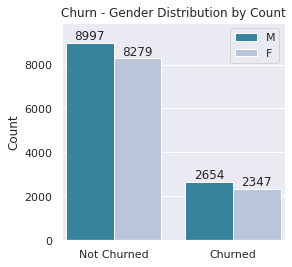

In [32]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax3 = sns.countplot(x="churn", data=df_panda, hue="gender",
                  palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax3.containers:
    ax3.bar_label(container)
ax3.set(xticklabels =["Not Churned", "Churned"])
ax3.legend(labels=["M", "F"])
plt.xlabel("")
plt.ylabel("Count")

# create title
plt.title("Churn - Gender Distribution by Count");


### <font color='blue'>Distribution of Churn on Level</font>

In [33]:
# counts of churn/non_churn users grouped by level
df_feats_cached.crosstab("churn", "level").sort("churn_level").show()

+-----------+----+-----+
|churn_level|   0|    1|
+-----------+----+-----+
|          0|7031|10245|
|          1|1579| 3422|
+-----------+----+-----+



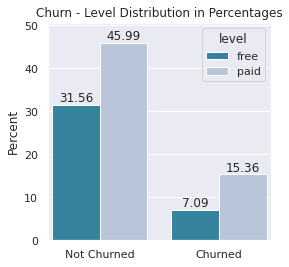

In [34]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax = sns.barplot(x="churn", y="churn", data=df_panda, 
                  estimator=lambda x: len(x) / len(df_panda) * 100, hue='level',
                  palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax.containers:
    ax.bar_label(container,  fmt='%.2f')
ax.set(xticklabels =["Not Churned", "Churned"])
plt.xlabel("")
plt.ylabel("Percent")

# restyle legend
labels = ['free', 'paid']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="level")

# create title
plt.title("Churn - Level Distribution in Percentages");

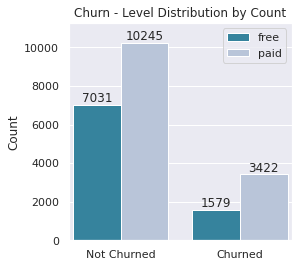

In [35]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(4,4)})
sns.set(font_scale=1)

# plot the churn distribution 
ax = sns.countplot(x="churn", data=df_panda, hue="level",
                  palette='PuBuGn_r')

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.02, y=0.1, tight=True);

# create labels and ticks
for container in ax.containers:
    ax.bar_label(container)
ax.set(xticklabels =["Not Churned", "Churned"])
ax.legend(labels=["free", "paid"])
plt.xlabel("")
plt.ylabel("Count")

# create title
plt.title("Churn - Level Distribution by Count");

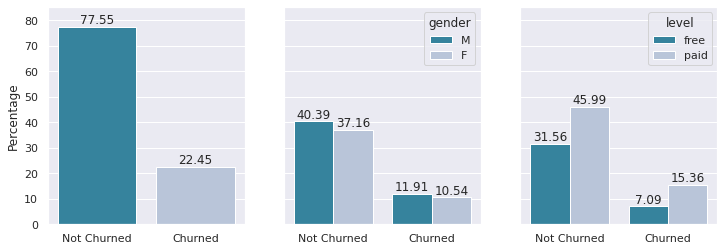

In [36]:
# combine all graphs together for use in the report

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(12,4)})
sns.set(font_scale=1)
f, axes = plt.subplots(1, 3, sharey=True)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=2, y=0.1, tight=True);

# plot the churn distribution 
ax = sns.barplot(x='churn', y='churn', data=df_panda, 
                 estimator=lambda x: len(x) / len(df_panda) * 100,
                 palette='PuBuGn_r',
                 ax=axes[0])
# create labels and ticks
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
ax.set(xticklabels =["Not Churned", "Churned"])
ax.set(xlabel="")
ax.set(ylabel="Percentage")


# plot the churn distribution with respect to gender
ax = sns.barplot(x='churn', y='churn', data=df_panda, 
                 estimator=lambda x: len(x) / len(df_panda) * 100, hue='gender',
                 palette='PuBuGn_r',
                 ax=axes[1])
# create labels and ticks
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
ax.set(xticklabels =["Not Churned", "Churned"])
ax.set(xlabel="")
ax.set(ylabel="")
# restyle the legend
labels = ['M', 'F']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="gender")

# plot the churn distribution with respect to level
ax = sns.barplot(x="churn", y="churn", data=df_panda, 
                  estimator=lambda x: len(x) / len(df_panda) * 100, hue='level',
                  palette='PuBuGn_r',
                  ax=axes[2])
# create labels and ticks
for container in ax.containers:
    ax.bar_label(container,  fmt='%.2f')
ax.set(xticklabels =["Not Churned", "Churned"])
ax.set(xlabel="")
ax.set(ylabel="")
# restyle the legend
labels = ['free', 'paid']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="level");

### <font color='blue'>Songs per Session for Churn and Not Churned</font>

In [37]:
# display statistics for songs played per session
df_feats_cached.describe("songs_per_session").show()

+-------+------------------+
|summary| songs_per_session|
+-------+------------------+
|  count|             22277|
|   mean|  65.5269198794409|
| stddev|41.382756448261496|
|    min|               0.0|
|    max|             579.0|
+-------+------------------+



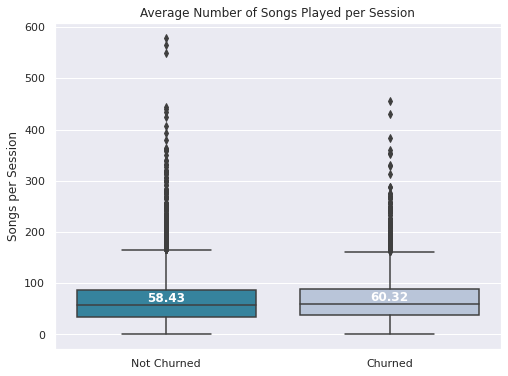

In [38]:
# adding labels to medians from:
# https://pretagteam.com/question/labeling-boxplot-in-seaborn-with-median-value

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,6)})
sns.set(font_scale=1)

# plot two boxplots
ax = sns.boxplot(x='churn', y = 'songs_per_session', 
                 data = df_panda,
                 palette='PuBuGn_r')

# label the median lines
medians = round(df_panda.groupby(['churn'])['songs_per_session'].median(), 2)
vertical_offset = df_panda['songs_per_session'].median() * 0.1 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Songs Played per Session')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("Songs per Session");

### <font color='blue'>Actions per Session for Churn and Not Churned</font>

In [39]:
# display statistics for actions played per session
df_feats_cached.describe("acts_per_session").show()

+-------+-----------------+
|summary| acts_per_session|
+-------+-----------------+
|  count|            22277|
|   mean|29.96367594024634|
| stddev|33.17610291712758|
|    min|              0.5|
|    max|            693.0|
+-------+-----------------+



Text(0, 0.5, 'Number of Items in Session')

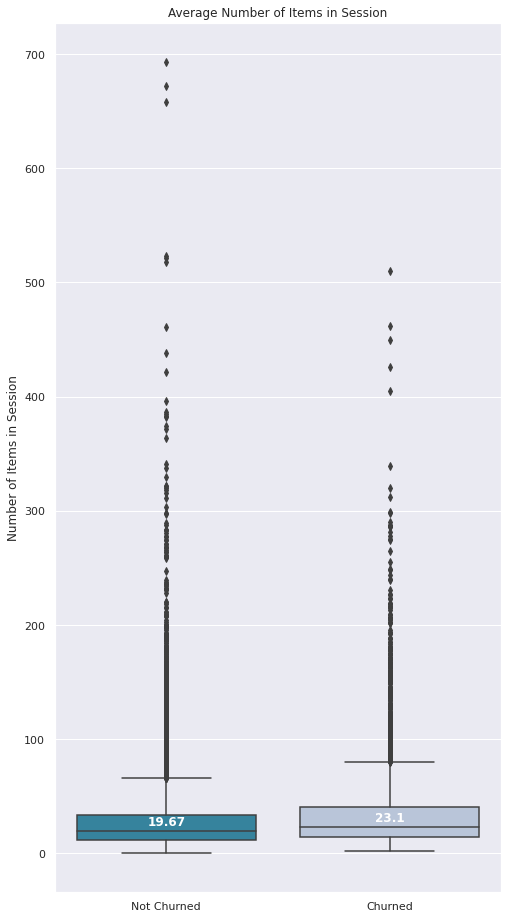

In [42]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,16)})
sns.set(font_scale=1)

# plot two boxplots
ax = sns.boxplot(x='churn', y = 'acts_per_session', 
                 data = df_panda,
                 palette='PuBuGn_r')

# label the median lines
medians = round(df_panda.groupby(['churn'])['acts_per_session'].median(), 2)
vertical_offset = df_panda['acts_per_session'].median() * 0.25 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Items in Session')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("Number of Items in Session")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


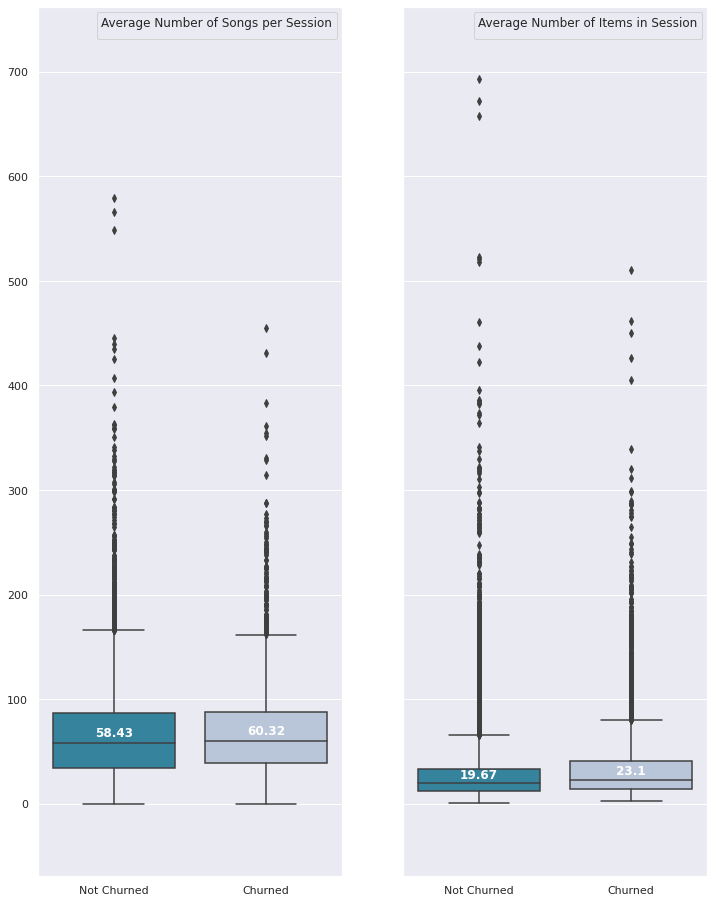

In [45]:

# combine the above two boxplots in one figure for use in the report

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(12,16)})
sns.set(font_scale=1)
f, axes = plt.subplots(1, 2, sharey=True)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=2, y=0.1, tight=True);


# plot left side boxplots
ax = sns.boxplot(x='churn', y = 'songs_per_session', 
                 data = df_panda,
                 palette='PuBuGn_r',
                 ax=axes[0])

# label the median lines
medians = round(df_panda.groupby(['churn'])['songs_per_session'].median(), 2)
vertical_offset = df_panda['songs_per_session'].median() * 0.1 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("");
ax.legend(title="Average Number of Songs per Session");

# plot right side boxplots
ax = sns.boxplot(x='churn', y = 'acts_per_session', 
                 data = df_panda,
                 palette='PuBuGn_r',
                 ax=axes[1])

# label the median lines
medians = round(df_panda.groupby(['churn'])['acts_per_session'].median(), 2)
vertical_offset = df_panda['acts_per_session'].median() * 0.25 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and lfeabels
plt.title('')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("");
ax.legend(title="Average Number of Items in Session");

### <font color='blue'>Received Ads per Session for Churn and Not Churned</font>

In [46]:
# display statistics for average number of ads received per session
df_feats_cached.describe("ads_per_session").show()

+-------+------------------+
|summary|   ads_per_session|
+-------+------------------+
|  count|             22277|
|   mean|1.6856580160429715|
| stddev|2.0476001330342277|
|    min|               0.0|
|    max|              36.0|
+-------+------------------+



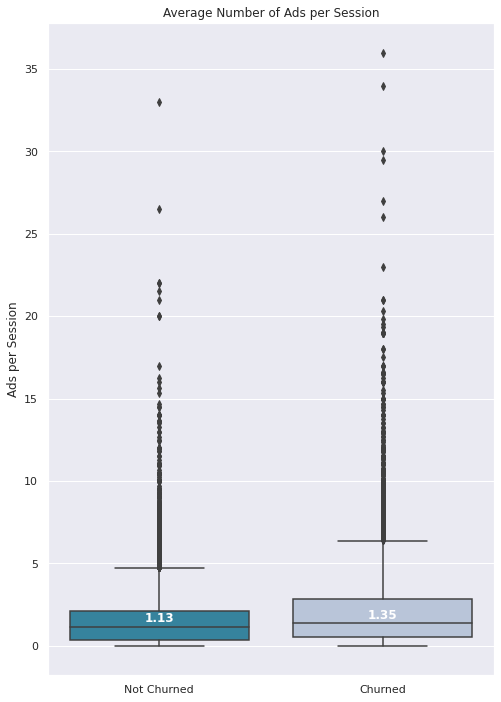

In [48]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,12)})
sns.set(font_scale=1)

# plot two boxplots
ax = sns.boxplot(x='churn', y = 'ads_per_session', 
                 data = df_panda,
                 palette='PuBuGn_r')

# label the median lines
medians = round(df_panda.groupby(['churn'])['ads_per_session'].median(), 2)
vertical_offset = df_panda['ads_per_session'].median() * 0.25 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number of Ads per Session')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("Ads per Session");

### <font color='blue'>Likes, Dislikes, Upgrades and Downgrades vs. Churn</font>

In [49]:
# statistics for the four features
df_feats_cached.describe(["nr_likes", "nr_dislikes", "nr_upgrades", "nr_downgrades"]).show()

+-------+-----------------+------------------+-----------------+------------------+
|summary|         nr_likes|       nr_dislikes|      nr_upgrades|     nr_downgrades|
+-------+-----------------+------------------+-----------------+------------------+
|  count|            22277|             22277|            22277|             22277|
|   mean|51.68851281590879| 10.73807065583337|2.267226287202047|  8.27041343089285|
| stddev|64.58937093224215|12.616020453772165|2.653005101910216|11.600411115347782|
|    min|                0|                 0|                0|                 0|
|    max|              836|               154|               29|               133|
+-------+-----------------+------------------+-----------------+------------------+



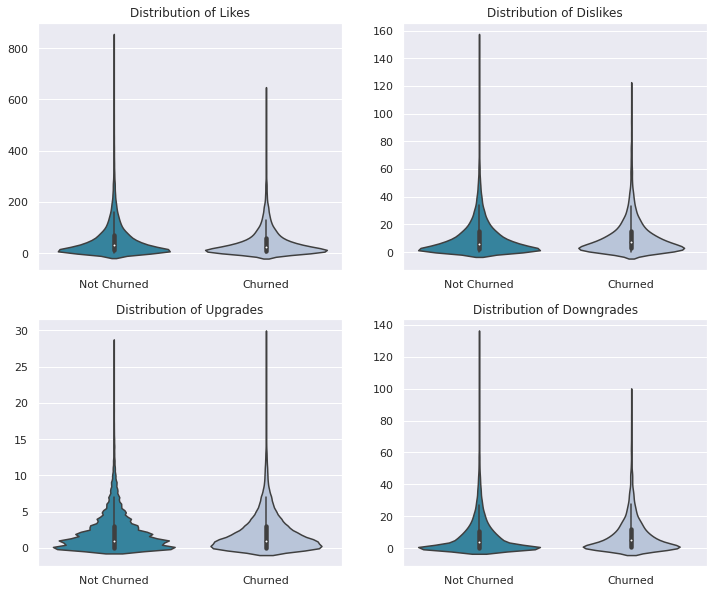

In [50]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(12,10)})
sns.set(font_scale=1)

# tick labels for x-axis
xticklabels = ['Not Churned', 'Churned'];

# plot on first row on left
plt.subplot(2,2,1)
ax1=sns.violinplot(data=df_panda, x="churn", y="nr_likes",
                   palette='PuBuGn_r');

plt.title("Distribution of Likes");
plt.xlabel("")
plt.ylabel("");
ax1.set_xticks([0, 1])
ax1.set_xticklabels(xticklabels);

# plot on first row on right
plt.subplot(2,2,2)
ax2=sns.violinplot(data=df_panda, x="churn", y="nr_dislikes",
                   palette='PuBuGn_r');

plt.title("Distribution of Dislikes");
plt.xlabel("")
plt.ylabel("");
ax2.set_xticks([0, 1])
ax2.set_xticklabels(xticklabels);

# plot on second row on left
plt.subplot(2,2,3)
ax3=sns.violinplot(data=df_panda, x='churn', y='nr_upgrades',
                   palette='PuBuGn_r');

plt.title("Distribution of Upgrades");
plt.xlabel("")
plt.ylabel("");
ax3.set_xticks([0, 1])
ax3.set_xticklabels(xticklabels);

# plot on second row on right
plt.subplot(2,2,4)
ax4=sns.violinplot(data=df_panda, x="churn", y='nr_downgrades',
                   palette='PuBuGn_r');

plt.title("Distribution of Downgrades");
plt.xlabel("")
plt.ylabel("");
ax4.set_xticks([0, 1])
ax4.set_xticklabels(xticklabels);

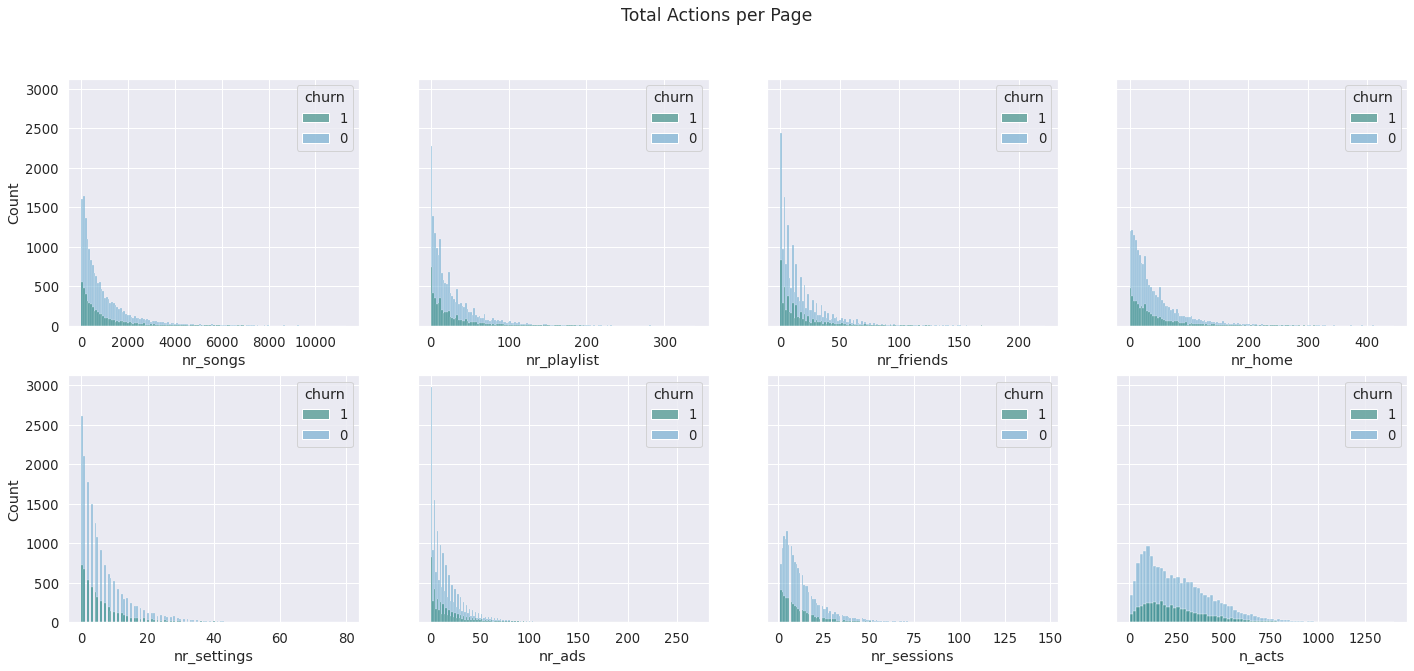

In [63]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,16)})
sns.set(font_scale=1.2)

# choose the individual plots figure properties
ncols = 4
nrows = 2
figsize = (ncols * 6, nrows * 5)

# assign fig and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True)
fig.suptitle("Total Actions per Page")

# data as pandas dataframe with selected columns
cols_to_plot = ["churn", "nr_songs", "nr_playlist",
                "nr_friends", "nr_home", 
                "nr_settings","nr_ads", "nr_sessions", "n_acts"]
data = df_panda[cols_to_plot]

# list of columns to plot
ylabels = cols_to_plot[1:]

# create a loop to plot each column
for i, y in enumerate(ylabels):
    sns.histplot(ax=axes[divmod(i, ncols)], data=data, x=y, hue="churn", 
                 hue_order=[1,0],  palette=[colors[0], colors[2]])

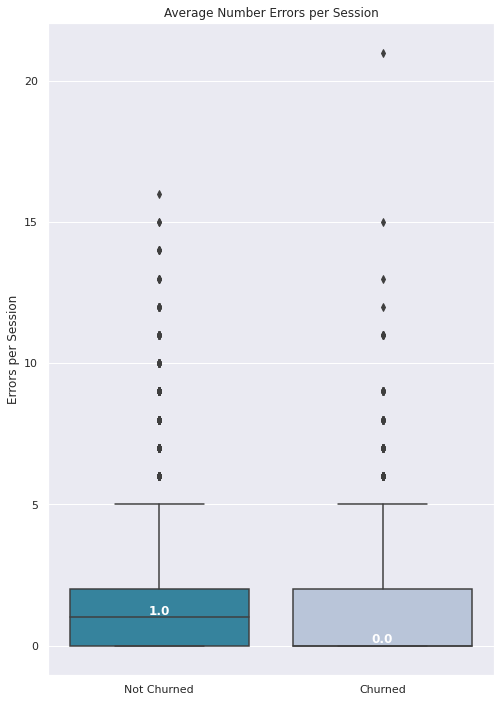

In [69]:
# adding labels to medians from:
# https://pretagteam.com/question/labeling-boxplot-in-seaborn-with-median-value

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(8,12)})
sns.set(font_scale=1)

# plot two boxplots
ax = sns.boxplot(x='churn', y = 'nr_error', 
                 data = df_panda,
                 palette='PuBuGn_r')

# label the median lines
medians = round(df_panda.groupby(['churn'])['nr_error'].median(), 2)
vertical_offset = df_panda['nr_error'].median() * 0.1 # offset from median

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick],
      horizontalalignment = "center", color = "w", weight = "bold")

# create title and labels
plt.title('Average Number Errors per Session')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("Errors per Session");

### <font color='blue'>Tenure days, active days and initial days intervals vs. Churn</font>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


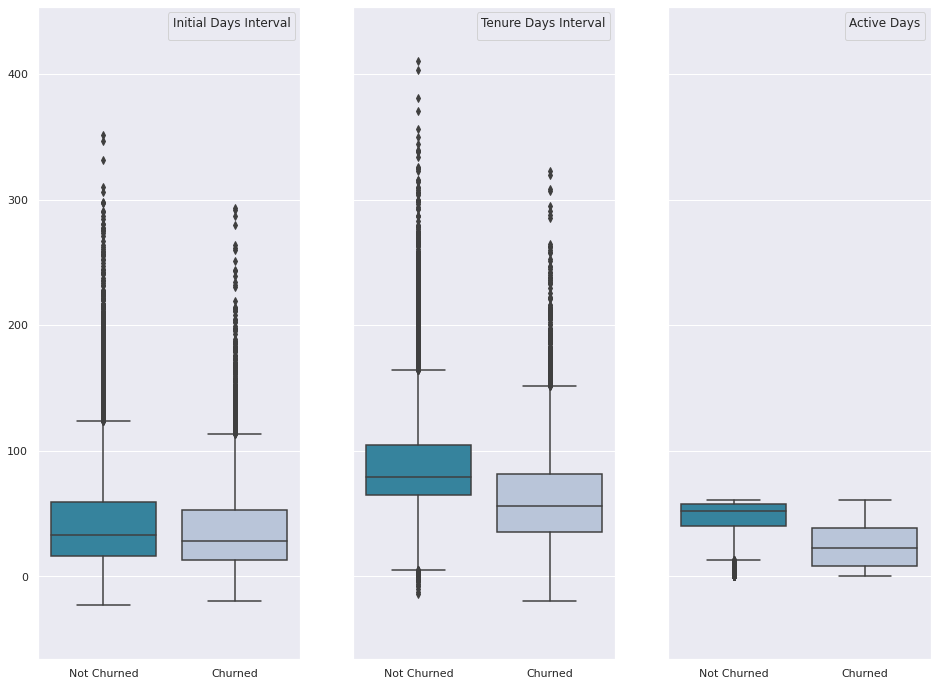

In [71]:
# combine the plots in one figure for use in the report

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,12)})
sns.set(font_scale=1)
f, axes = plt.subplots(1, 3, sharey=True)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=2, y=0.1, tight=True);


# plot left side boxplots
ax = sns.boxplot(x='churn', y = 'init_days_interv', 
                 data = df_panda,
                 palette='PuBuGn_r',
                 ax=axes[0])

# create title and labels
plt.title('')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("");
ax.legend(title="Initial Days Interval");

# plot middle boxplots
ax = sns.boxplot(x='churn', y = 'tenure_days_interv', 
                 data = df_panda,
                 palette='PuBuGn_r',
                 ax=axes[1])

# create title and labels
plt.title('')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("");
ax.legend(title="Tenure Days Interval");

# plot right side boxplots
ax = sns.boxplot(x='churn', y = 'active_days', 
                 data = df_panda,
                 palette='PuBuGn_r',
                 ax=axes[2])

# create title and labels
plt.title('')
ax.set(xticklabels=['Not Churned', 'Churned'])
ax.set_xlabel("")
ax.set_ylabel("");
ax.legend(title="Active Days");

## <font color='blue'>Split the Data</font>



<div class="alert alert-block alert-info">
    
The dataset is imbalanced, and in order to ensure that the train set and the test set contain the same percentages of each class we will use stratified split.
    
</div>

In [72]:
# source: https://stackoverflow.com/questions/47637760/stratified-sampling-with-pyspark
SPLIT_VALS = [.7, .3]

# split the data into train and test sets

def split_data (df):
    
    """
    Split the dataset into training set and test set.
    Use a stratified sampling method.
    """
    #train_set, test_set = df.randomSplit(SPLIT_VALS,seed=1234)
    
    # split dataframes between 0s and 1s
    zeros = df_feats.filter(df_feats["churn"]==0)
    ones = df_feats.filter(df_feats["churn"]==1)
    
    # split datasets into training and testing
    train0, test0 = zeros.randomSplit(SPLIT_VALS, seed=1234)
    train1, test1 = ones.randomSplit(SPLIT_VALS, seed=1234)

    # stack datasets back together
    train_set = train0.union(train1)
    test_set = test0.union(test1)
    
    return train_set, test_set

In [73]:
# split the data in training set and test set
train_set, test_set = split_data(df_feats_cached)

In [74]:
# print the size of each subset
print("The train set has {} records and the test set has {} records.".format(train_set.count(), test_set.count()))

The train set has 15438 records and the test set has 6839 records.


### <font color='blue'>Toggle the memory</font>

In [75]:
# remove features dataset from memory
df_feats_cached.unpersist()

DataFrame[nr_songs: bigint, nr_playlist: bigint, nr_friends: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_home: bigint, nr_settings: bigint, nr_error: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, avg_sess_h: double, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: double, tenure_days_interv: double, active_days: double, gender: int, level: int, churn: int]

In [76]:
# add the train set to the memory
train_cached = train_set.cache()

## <font color='blue'>Feature Relevance</font>

### <font color='blue'>Normalized Median Difference Churn vs. Not Churn</font>

In [77]:
def median_diff(df, col, bincol):
    
    """
    Given the values in a column, computes the normalized difference between the medians 
    of the subsets based on values in a categorical column.
    
    INPUT:
        df (Pandas dataframe) - dataframe that contains both columns
        col (Pandas series) - column in df, of integer, float type
        bincol (Pandas series) - column in df, with entries 0, 1
    OUTPUT:
        dictionary: key = nd_col, value = normalized_diff
    """
    median_one = abs(df[df[bincol]==1][col].median())
    median_zero = abs(df[df[bincol]==0][col].median())
    normalized_difference = (median_one - median_zero)/max(median_zero, median_one)
    return {"column": f"nd_{col}",
            "normal_diff": normalized_difference}    

In [78]:
# save the dataframe in pandas
train_panda = train_cached.toPandas()
# the numerical columns
num_cols = train_panda.columns[:20]

# create a Pandas dataframe with the normalized median differences
df_medians = pd.DataFrame(list(map(lambda col: median_diff(train_panda, col, "churn"), num_cols)))
df_medians = df_medians.sort_values(["normal_diff"], ascending = False).reset_index(drop = True)
df_medians

22/01/18 21:36:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 21:36:43 WARN RowBasedKeyValueBatch: Calling spill() on

,column,normal_diff
0,nd_nr_downgrades,0.200000
1,nd_nr_ads,0.166667
2,nd_ads_per_session,0.156250
3,nd_nr_dislikes,0.142857
4,nd_acts_per_session,0.142014
5,nd_songs_per_session,0.017130
6,nd_nr_upgrades,0.000000
7,nd_nr_settings,0.000000
8,nd_avg_sess_h,-0.042700
9,nd_n_acts,-0.045872


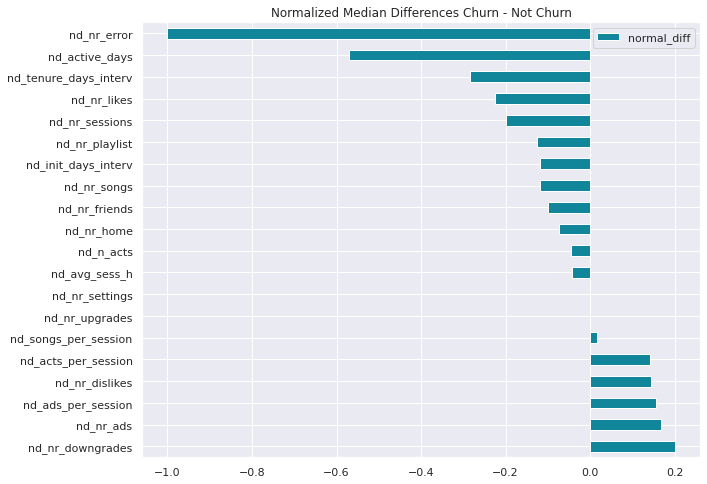

In [79]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(10, 8)})
sns.set(font_scale=1)

ax = df_medians.plot.barh(x='column', y='normal_diff', 
                         color=colors[1], rot=0)

# create title and labels
plt.title("Normalized Median Differences Churn - Not Churn")
ax.set_xlabel("");
ax.set_ylabel("");

### <font color='blue'>Using Kendall rank correlation coefficient</font>

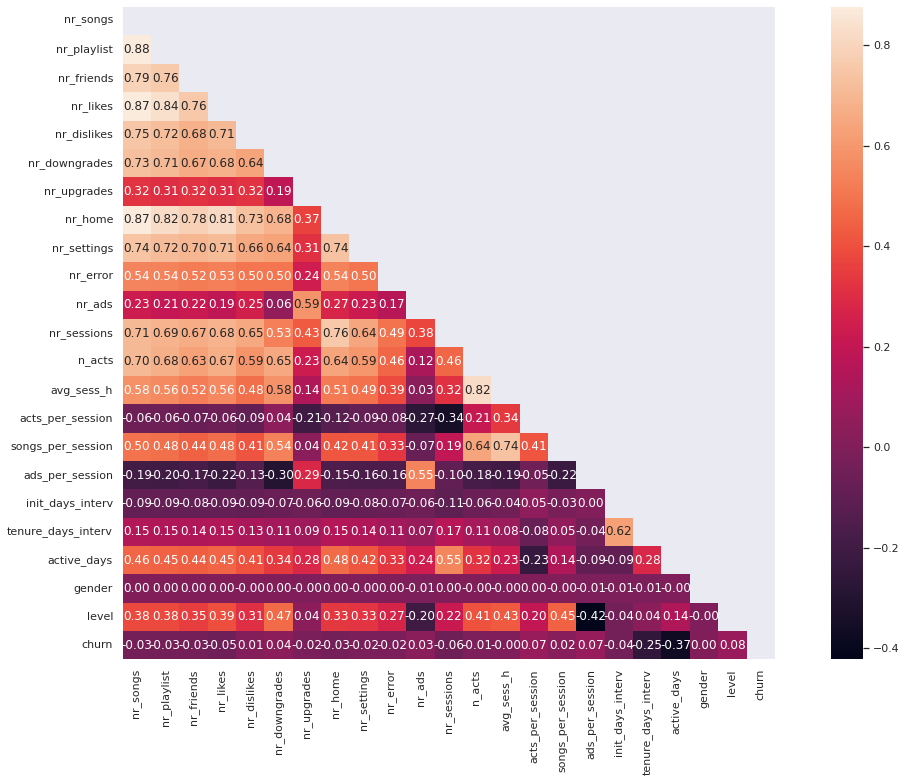

In [80]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(20, 12)})
sns.set(font_scale=1)

# compute the correlation matrix using 
corr = train_cached.toPandas().corr(method='kendall')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,annot=True, fmt='.2f', square=True, mask = mask);

In [81]:
# the correlation indices with respect to "churn" 
corr_indices = pd.DataFrame(corr["churn"].sort_values(ascending=False))
corr_indices = corr_indices.reset_index().rename({'index':'features', 'churn': 'kendall_corr'}, axis = 'columns')
corr_indices = corr_indices.iloc[1: , :]
corr_indices

,features,kendall_corr
1,level,0.077789
2,acts_per_session,0.072503
3,ads_per_session,0.067888
4,nr_downgrades,0.036038
5,nr_ads,0.028258
6,songs_per_session,0.021622
7,nr_dislikes,0.012471
8,gender,0.001830
9,avg_sess_h,-0.001219
10,n_acts,-0.010337


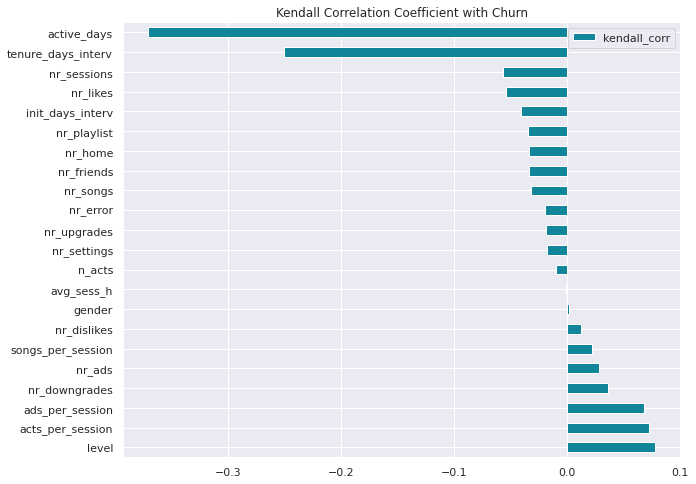

In [82]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(10, 8)})
sns.set(font_scale=1)

ax = corr_indices.plot.barh(x='features', y='kendall_corr', 
                         color=colors[1], rot=0)

# create title and labels
plt.title("Kendall Correlation Coefficient with Churn")
ax.set_xlabel("");
ax.set_ylabel("");

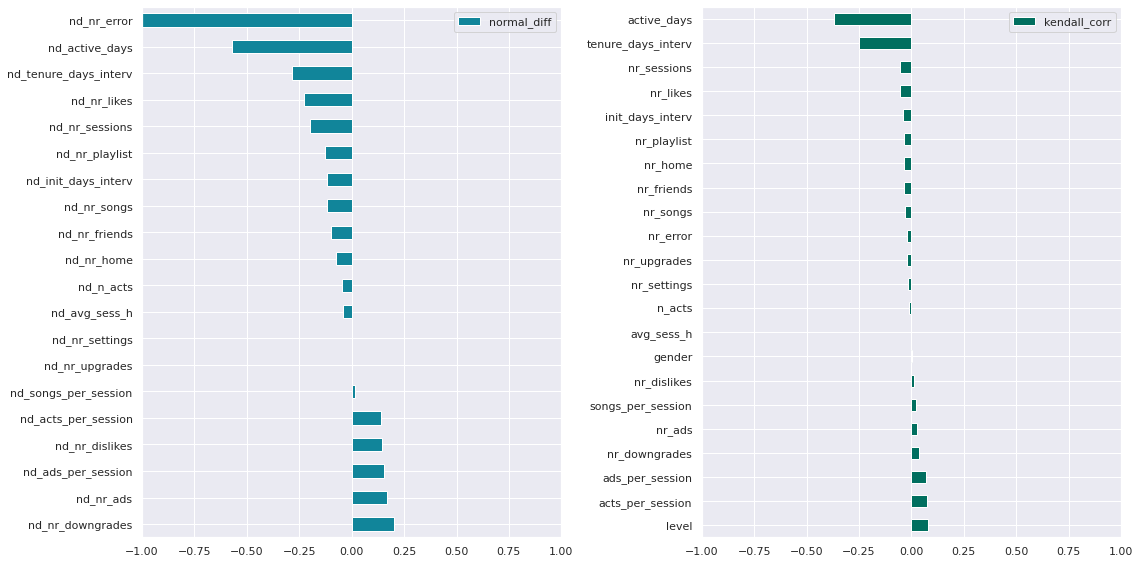

In [86]:
# combine the above two boxplots in one figure

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,8)})
plt.rcParams["figure.autolayout"] = True
sns.set(font_scale=1)

f, axes = plt.subplots(1, 2, sharey=False)


# pad margins so that markers don't get clipped by the axes
plt.margins(x=4, y=0.1, tight=True);


ax = df_medians.plot.barh(x='column', y='normal_diff', 
                         color=colors[1], rot=0, ax=axes[0])

# label for y-axis
ax.set_xlabel("");
ax.set_xlim(-1,1)
ax.set_ylabel("");


# adjust figure size and font size
sns.set(rc = {"figure.figsize":(10, 8)})
sns.set(font_scale=1)

ax = corr_indices.plot.barh(x='features', y='kendall_corr', 
                         color=colors[0], rot=0, ax=axes[1])

# label for y-axis
ax.set_xlabel("");
ax.set_xlim(-1,1)
ax.set_ylabel("");


<div class="alert alert-block alert-info">

From the above bar plots it looks like the number of upgrades is an irrelevant feature to include, so we might drop it in the modeling phase. However, we must keep in mind that this conclusion is based on the mini data, and we have to check what happens with in the full data set case.
    
<div>

In [87]:
features_full_data_path = "data/full_sparkify_features_data.json"
save_data(df_feats, features_full_data_path)

22/01/18 22:20:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/01/18 22:20:59 WARN RowBasedKeyValueBatch: Calling spill() on

## <font color='blue'>Modeling</font>

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### <font color='blue'>Build Pipeline</font>

In [89]:
# split the features and the label
CAT_FEATURES = ["gender", "level", "downgrade"]
CONT_FEATURES = ["nr_songs", "nr_likes", "nr_dislikes", "nr_playlist", "nr_friends", "nr_downgrades",
                "nr_upgrades", "nr_home", "nr_error", "nr_settings", "nr_ads", "nr_sessions",
                "n_acts", "avg_sess_h", "acts_per_session", "songs_per_session", "ads_per_session",
                "init_days_interv", "tenure_days_interv", "active_days"]
CHURN_LABEL = "churn"


def build_pipeline(classifier):
    """
    Combines all the stages of the processing data. 
    """
    # stages in the pipeline
    stages = [] 
    
    # encode the labels
    label_indexer =  StringIndexer(inputCol=CHURN_LABEL, outputCol="label")
    stages += [label_indexer]
    
    # encode the binary features
    bin_assembler = VectorAssembler(inputCols=CAT_FEATURES, outputCol="bin_features")
    stages += [bin_assembler]
    
    # encode the continuous features
    cont_assembler = VectorAssembler(inputCols = CONT_FEATURES, outputCol="cont_features")
    stages += [cont_assembler]
    # normalize the continuous features
    cont_scaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaler", 
                                 withStd=True , withMean=True)
    stages += [cont_scaler]
    
    # pass all to the vector assembler to create a single sparse vector
    all_assembler = VectorAssembler(inputCols=["bin_features", "cont_scaler"],  
                            outputCol="features")
    stages += [all_assembler]
    
    # add the model to the pipeline
    stages += [classifier]
    
    # create a pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline

### <font color='blue'>Build Individual ML Pipelines</font>

In [ ]:
# train a Logistic Regression model
def logistic_regression_pipeline():
    lr_classifier = LogisticRegression(labelCol = "label",
                                       featuresCol = "features")
    return build_pipeline(lr_classifier)

# train a Decision Tree model
def decision_tree_pipeline():
    dt_classifier = DecisionTreeClassifier(labelCol = "label",
                                           featuresCol = "features",
                                           seed=1234)
    return build_pipeline(dt_classifier)

# train a Random Forest model
def random_forest_pipeline():
    rf_classifier = RandomForestClassifier(labelCol = "label",
                                           featuresCol = "features", 
                                           seed=1234)
    return build_pipeline(rf_classifier)

# train a Gradient-boosted Tree model
def gradient_boosted_pipeline():
    gbt_classifier = GBTClassifier(labelCol = "label",
                                   featuresCol = "features",
                                   seed=1234)
    return build_pipeline(gbt_classifier)

# train a Multilayer Perceptron Classifier
def multilayer_perceptron_pipeline():
    # specify layers: 23 (features), two intermediate (8, 4), output 2 (classes)
    layers=[23, 8, 4, 2]
    # create the trainer and set its parameters
    mlpc_classifier = MultilayerPerceptronClassifier(labelCol = "label",
                                                     featuresCol = "features",
                                                     layers=layers,
                                                     seed=1234)
    return build_pipeline(mlpc_classifier)

### <font color='blue'>Build K-Fold Cross Validation and Grid Search Pipelines</font>

In [34]:
# implement K-fold cross validation and grid search 

def grid_search_model(pipeline, param):
    """
    Creates a cross validation object.
    
    INPUT:
        param = grid of parameter
        pipeline = model pipeline 
    
    OUTPUT:
        cv = cross validation object
    """
    evaluator = BinaryClassificationEvaluator()
    cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param,
                    evaluator=evaluator,
                    numFolds=5,
                    parallelism=2)
    return cv

In [51]:
# model_name = "Logistic_Regression"
def lr_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_lr = ParamGridBuilder()
    param_lr = param_lr.addGrid(model.regParam, [.1, .5, 2]) #[.01])
    param_lr = param_lr.addGrid(model.elasticNetParam,  [.1, 1]) #[.5])
    param_lr = param_lr.build()
    
    print(f"Models trained: {len(param_lr)}")
    
    return grid_search_model(pipeline, param_lr)


# model_name = "Decision Trees"
def dt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_dt = ParamGridBuilder()
    param_dt = param_dt.addGrid(model.maxDepth, [5, 10, 15, 25]) #[25]) 
    param_dt = param_dt.addGrid(model.maxBins, [8, 16, 32]) # [32]) 
    param_dt = param_dt.build()
    
    print(f"Models trained: {len(param_dt)}")
    
    return grid_search_model(pipeline, param_dt)


# model_name = "Random Forest"
def rf_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_rf = ParamGridBuilder()
    param_rf = param_rf.addGrid(model.maxDepth, [10, 15, 25]) #[15]) 
    param_rf = param_rf.addGrid(model.maxBins, [8, 16, 32]) # [32]) 
    param_rf = param_rf.addGrid(model.numTrees, [20, 40, 60]) #[60])
    param_rf = param_rf.build()
    
    print(f"Models trained: {len(param_rf)}")
    
    return grid_search_model(pipeline, param_rf)


# model_name = "Gradient Boosted Trees"
def gbt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_gbt = ParamGridBuilder()
    param_gbt = param_gbt.addGrid(model.maxDepth, [10, 15, 25]) #[15])
    param_gbt = param_gbt.addGrid(model.maxIter, [10, 20, 30]) #[20]) 
    param_gbt = param_gbt.addGrid(model.stepSize, [.05, .1]) #[.1])
    param_gbt = param_gbt.build()
    
    print(f"Models trained: {len(param_gbt)}")
    
    return grid_search_model(pipeline, param_gbt)


# model_name = "Multilayer Perceptron Classifier"
def mlpc_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_mlpc = ParamGridBuilder()
    param_mlpc = param_mlpc.addGrid(model.stepSize, [.01, .02,.05]) #[.02])
    param_mlpc = param_mlpc.addGrid(model.maxIter, [32, 64, 128, 256]) #[128])
    param_mlpc = param_mlpc.build()
    
    print(f"Models trained: {len(param_mlpc)}")
    
    return grid_search_model(pipeline, param_mlpc)

### <font color='blue'>Build Models Evaluators</font>

In [43]:
# function to compute relevant metrics for binary classification
def conf_metrics(dataset):
    
    """
        Calculates the metrics associated to the confusion matrix.

        INPUT:
            dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        OUTPUT:
            accuracy (float) - metric
            precision (float) - metric
            recall (float) - metric
            F1 (float) - metric
    """
   

    # calculate the elements of the confusion matrix
    tn = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==0)).count()
    tp = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==1)).count()                   
    fn = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==0)).count()                   
    fp = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==1)).count()
    
    # calculate accuracy, precision, recall, and F1-score
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  2 * (precision*recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

In [44]:
def display_metrics(dataset, roc_cl, pr_cl):
    
    """
    Prints evaluation metrics for the model. 
    
    INPUT:
         dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
    
    """
    
    accuracy = conf_metrics(dataset)[0]
    precision = conf_metrics(dataset)[1]
    recall = conf_metrics(dataset)[2]
    f1 = conf_metrics(dataset)[3]
    
    print("")
    print("Confusion Matrix")
    dataset.groupBy(dataset[labelCol], dataset[predCol]).count().show()
    print("")
    print("accuracy...............%6.3f" % accuracy)
    print("precision..............%6.3f" % precision)
    print("recall.................%6.3f" % recall)
    print("F1.....................%6.3f" % f1)
    print("auc_roc................%6.3f" % roc_cl)
    print("auc_pr.................%6.3f" % pr_cl)


## <font color='blue'>Train, Tune and Evaluate the Classifiers</font>

In [38]:
# split the data in training set and test set
train_set, test_set = split_data(df_feats)

In [39]:
train_set.persist(), test_set.persist()

(DataFrame[nr_songs: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_playlist: bigint, nr_friends: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_home: bigint, nr_error: bigint, nr_settings: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, avg_sess_h: double, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: int, tenure_days_interv: int, active_days: bigint, gender: int, level: int, downgrade: int, churn: int],
 DataFrame[nr_songs: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_playlist: bigint, nr_friends: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_home: bigint, nr_error: bigint, nr_settings: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, avg_sess_h: double, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: int, tenure_days_interv: int, active_days: bigint, gender: int, level: int, downgrade: int, churn: int])

### <font color='blue'>Combine All Steps</font>

In [40]:
def train_evaluate_tune(model_name, classifier_pipeline, cv_pipeline):
    
    """
    The following steps are performed:
        - build the classifier,
        - run a grid search with cross validation, 
        - train the classifier on the train set,
        - build predictions on the test set,
        - compute and print training time and evaluation metrics
        
    INPUT:
        model_name (str)
        classifier_pipeline (pipeline object)
        cv_pipeline (cross validator)
    
    """
    
    print("")
    print("Training .....{}.".format(model_name))
    print("")
    
    # name the relevant columns
    predCol="prediction"
    labelCol="label"
    
    # build specific pipeline
    pipeline = classifier_pipeline()
    
    # choose an evaluator
    evaluator = BinaryClassificationEvaluator()
    evaluator.setLabelCol(labelCol)
    
    # build the grid search pipeline
    cv = cv_pipeline(pipeline)
    
    # start time
    start_time = time.time()
    
    # train the model
    model = cv.fit(train_set)
    
    # stop timer
    end_time = time.time()
    
    # evaluate the trainining time in minutes 
    train_time = (end_time - start_time)/60
    
    # print the training time
    print("")
    print("Training time.........%6.2f min" % train_time)
    
    # create the predictions dataset
    results = model.bestModel.transform(test_set)
    
    # calculate auc metric
    roc = evaluator.evaluate(results, {evaluator.metricName: "areaUnderROC"})
    pr = evaluator.evaluate(results, {evaluator.metricName: "areaUnderPR"})
    
    # print all other evaluation metrics
    print("")
    display_metrics(results)
    print("")

In [41]:
models_info = [["LOGISTIC REGRESSION CLASSIFIER", logistic_regression_pipeline, lr_grid_search],
          ["DECISION TREE CLASSIFIER", decision_tree_pipeline, dt_grid_search],
          ["RANDOM FOREST CLASSIFIER", random_forest_pipeline, rf_grid_search],
          ["GRADIENT BOOSTED TREES", gradient_boosted_pipeline, gbt_grid_search],
          ["MULTILAYER PERCEPTRON CLASSIFIER", multilayer_perceptron_pipeline, mlpc_grid_search]]

### <font color='blue'>Logistic Regression Classifier</font>

In [45]:
print("")
print(f"Training LOGISTIC REGRESSION CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = logistic_regression_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
lr = lr_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_lr = lr.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_lr = model_lr.bestModel.transform(test_set)

# calculate auc metrics
roc_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
pr_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_lr, prec_lr, rec_lr, f1_lr = conf_metrics(predictions_lr)

# print all evaluation metrics
print("")
display_metrics(predictions_lr, roc_lr, pr_lr)
print("")

# print the best parameters from the grid
best_model_lr = model_lr.bestModel.stages[-1]
param_lr1 = best_model_lr.getRegParam()
param_lr2 = best_model_lr.getElasticNetParam()
print("The best hyperparameter values from the grid:")
print("regNetParam:..........", param_lr1)
print("elasticNetParam:......", param_lr2)


Training LOGISTIC REGRESSION CLASSIFIER

Models trained: 1


21/12/23 15:21:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/23 15:21:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS



Training time......... 2.908 min




Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    9|
|  0.0|       1.0|    4|
|  1.0|       0.0|    4|
|  0.0|       0.0|   42|
+-----+----------+-----+


accuracy............... 0.864
precision.............. 0.692
recall................. 0.692
F1..................... 0.692
auc_roc................ 0.851
auc_pr................. 0.698

The best hyperparameter values from the grid:
regNetParam:.......... 0.01
elasticNetParam:...... 0.5


### <font color='blue'>Decision Trees Classifier</font>

In [46]:
print("")
print(f"Training DECISION TREES CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = decision_tree_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
dt = dt_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_dt = dt.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_dt = model_dt.bestModel.transform(test_set)

# calculate auc metrics
roc_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})
pr_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_dt, prec_dt, rec_dt, f1_dt = conf_metrics(predictions_dt)

# print all evaluation metrics
print("")
display_metrics(predictions_dt, roc_dt, pr_dt)
print("")

# print the best parameters from the grid
best_model_dt = model_dt.bestModel.stages[-1]
param_dt1 = best_model_dt.getMaxDepth()
param_dt2 = best_model_dt.getMaxBins()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_dt1)
print("maxBins:...........", param_dt2)


Training DECISION TREES CLASSIFIER

Models trained: 1

Training time......... 0.389 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    6|
|  0.0|       1.0|   12|
|  1.0|       0.0|    7|
|  0.0|       0.0|   34|
+-----+----------+-----+


accuracy............... 0.678
precision.............. 0.333
recall................. 0.462
F1..................... 0.387
auc_roc................ 0.622
auc_pr................. 0.387

The best hyperparameter values from the grid:
maxDepth:.......... 25
maxBins:........... 32


### <font color='blue'>Random Forest Classifier</font>

In [47]:
print("")
print(f"Training RANDOM FOREST CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = random_forest_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
rf = rf_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_rf = rf.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_rf = model_rf.bestModel.transform(test_set)

# calculate auc metrics
roc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
pr_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_rf, prec_rf, rec_rf, f1_rf = conf_metrics(predictions_rf)

# print all evaluation metrics
print("")
display_metrics(predictions_rf, roc_rf, pr_rf)
print("")

best_param_rf = list(model_rf.getEstimatorParamMaps()[np.argmax(model_rf.avgMetrics)].values())
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", best_param_rf[0])
print("maxBins:...........", best_param_rf[1])
print("numTrees:..........", best_param_rf[2])


Training RANDOM FOREST CLASSIFIER

Models trained: 1



Training time......... 1.196 min




Confusion Matrix


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    5|
|  1.0|       0.0|    8|
|  0.0|       0.0|   46|
+-----+----------+-----+


accuracy............... 0.864
precision.............. 1.000
recall................. 0.385
F1..................... 0.556
auc_roc................ 0.746
auc_pr................. 0.645

The best hyperparameter values from the grid:
maxDepth:.......... 15
maxBins:........... 32
numTrees:.......... 60


### <font color='blue'>Gradient Boosted Trees</font>

In [48]:
print("")
print(f"Training GRADIENT BOOSTED TREES")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = gradient_boosted_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
gbt = gbt_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_gbt = gbt.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_gbt = model_gbt.bestModel.transform(test_set)

# calculate auc metrics
roc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
pr_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_gbt, prec_gbt, rec_gbt, f1_gbt = conf_metrics(predictions_gbt)

# print all evaluation metrics
print("")
display_metrics(predictions_gbt, roc_gbt, pr_gbt)
print("")

# print the best parameters from the grid
best_model_gbt = model_gbt.bestModel.stages[-1]
param_gbt1 = best_model_gbt.getMaxDepth()
param_gbt2 = best_model_gbt.getMaxIter()
param_gbt3 = best_model_gbt.getStepSize()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_gbt1)
print("maxIter:...........", param_gbt2)
print("stepSize:..........", param_gbt3)


Training GRADIENT BOOSTED TREES

Models trained: 1

Training time......... 5.043 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    6|
|  0.0|       1.0|   12|
|  1.0|       0.0|    7|
|  0.0|       0.0|   34|
+-----+----------+-----+


accuracy............... 0.678
precision.............. 0.333
recall................. 0.462
F1..................... 0.387
auc_roc................ 0.650
auc_pr................. 0.288

The best hyperparameter values from the grid:
maxDepth:.......... 15
maxIter:........... 20
stepSize:.......... 0.1


### <font color='blue'>Multilayer Perceptron Classifier</font>

In [49]:
print("")
print(f"Training MULTILAYER PERCEPTRON CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = multilayer_perceptron_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
mlpc = mlpc_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_mlpc = mlpc.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_mlpc = model_mlpc.bestModel.transform(test_set)

# calculate auc metrics
roc_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderROC"})
pr_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc = conf_metrics(predictions_mlpc)

# print all evaluation metrics
print("")
display_metrics(predictions_mlpc, roc_mlpc, pr_mlpc)
print("")

# print the best parameters from the grid
best_model_mlpc = model_mlpc.bestModel.stages[-1]
param_mlpc1 = best_model_mlpc.getStepSize()
param_mlpc2 = best_model_mlpc.getMaxIter()
param_mlpc3 = best_model_mlpc.getBlockSize()
print("The best hyperparameter values from the grid:")
print("stepSize:..........", param_mlpc1)
print("maxIter:...........", param_mlpc2)
print("blockSize:.........", param_mlpc3)


Training MULTILAYER PERCEPTRON CLASSIFIER

Models trained: 1

Training time......... 3.065 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    7|
|  0.0|       1.0|   10|
|  1.0|       0.0|    6|
|  0.0|       0.0|   36|
+-----+----------+-----+


accuracy............... 0.729
precision.............. 0.412
recall................. 0.538
F1..................... 0.467
auc_roc................ 0.724
auc_pr................. 0.411

The best hyperparameter values from the grid:
stepSize:.......... 0.02
maxIter:........... 128
blockSize:......... 128


## <font color='blue'>Discuss the Best Model</font>

In [53]:
# create Pandas dataframe with metrics
dict_metrics = {"LinReg": [acc_lr, prec_lr, rec_lr, f1_lr, roc_lr, pr_lr],
                "DecTrees": [acc_dt, prec_dt, rec_dt, f1_dt, roc_dt, pr_dt], 
                "RandForest": [acc_rf, prec_rf, rec_rf, f1_rf, roc_rf, pr_rf],
                "GradBoost": [acc_gbt, prec_gbt, rec_gbt, f1_gbt, roc_gbt, pr_gbt],
                "MultiLPerceptron": [acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc, roc_mlpc, pr_mlpc],
                "list_metrics" : ["accuracy", "precision", "recall", "f1_score", "auc_roc", "auc_pr"]
               }
df_mets = pd.DataFrame.from_dict(dict_metrics).set_index("list_metrics")
df_mets.round(3)

,LinReg,DecTrees,RandForest,GradBoost,MultiLPerceptron
list_metrics,,,,,
accuracy,0.864,0.678,0.864,0.678,0.729
precision,0.692,0.333,1.000,0.333,0.412
recall,0.692,0.462,0.385,0.462,0.538
f1_score,0.692,0.387,0.556,0.387,0.467
auc_roc,0.851,0.622,0.746,0.650,0.724
auc_pr,0.698,0.387,0.645,0.288,0.411


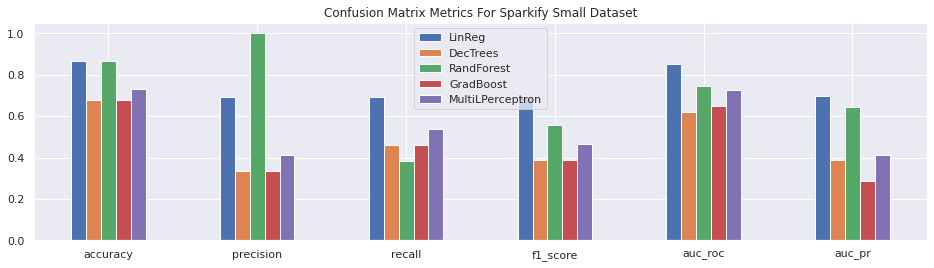

In [54]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,4)})

sns.set(font_scale=1)
ax = df_mets.plot.bar(y=["LinReg", "DecTrees", "RandForest", "GradBoost", "MultiLPerceptron"], rot=0)

# create title and labels
plt.title("Confusion Matrix Metrics For Sparkify Small Dataset")
ax.set_xlabel("");
ax.set_ylabel("");